In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv(r"Mall_Customers.csv")

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [55]:
data["Gender"].unique()

array(['Male', 'Female'], dtype=object)

In [56]:
data["Gender"] = data["Gender"].apply(lambda x: 0 if x=="Male" else 1)

In [57]:
data = data.drop("CustomerID", axis=1)

In [58]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data)
scaled = pd.DataFrame(scaled, columns=data.columns)

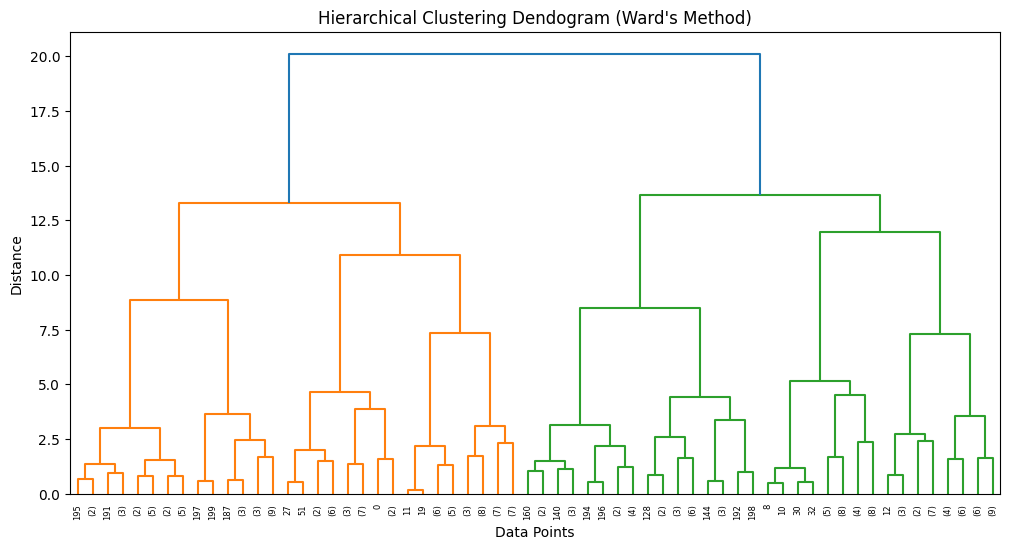

In [59]:
linkage_matrix = linkage(scaled, method = "ward")
plt.figure(figsize=(12,6))
dendrogram(linkage_matrix, truncate_mode = "level", p=5)
plt.title("Hierarchical Clustering Dendogram (Ward's Method)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

In [60]:
# dendogram is complex let us rely on silhouette score and elbow method

In [61]:
for_diag = []
for n_clusters in range(2,20):
    clusterer = AgglomerativeClustering(n_clusters = n_clusters, linkage = "ward")
    labels = clusterer.fit_predict(scaled)
    silhouette_avg = silhouette_score(scaled, labels)
    for_diag.append(silhouette_avg)
    print(f"For {n_clusters} silhouette score = {silhouette_avg}")

For 2 silhouette score = 0.24177953745462927
For 3 silhouette score = 0.24834537795671963
For 4 silhouette score = 0.26322605188202447
For 5 silhouette score = 0.28699413201651747
For 6 silhouette score = 0.31024459685260536
For 7 silhouette score = 0.34555782664693324
For 8 silhouette score = 0.3788796050129373
For 9 silhouette score = 0.39225805358687793
For 10 silhouette score = 0.4176254448686808
For 11 silhouette score = 0.42517748630372254
For 12 silhouette score = 0.42440324303677535
For 13 silhouette score = 0.4198062925672963
For 14 silhouette score = 0.4254321544952805
For 15 silhouette score = 0.4344600643875796
For 16 silhouette score = 0.43932320264453567
For 17 silhouette score = 0.4206944029733773
For 18 silhouette score = 0.42765394339048635
For 19 silhouette score = 0.42525042765449045


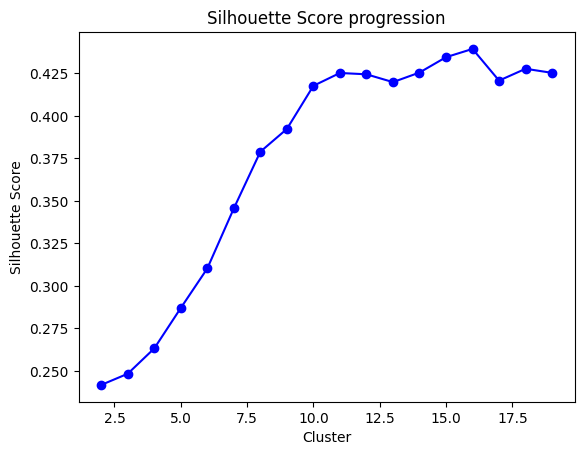

In [62]:
plt.plot(range(2,20), for_diag, "bo-")
plt.xlabel("Cluster")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score progression")
plt.show()

In [63]:
# optimal number of clusters 8

In [64]:
final_clusters = AgglomerativeClustering(n_clusters=8, linkage="ward")
scaled["clusters1"] = final_clusters.fit_predict(scaled)

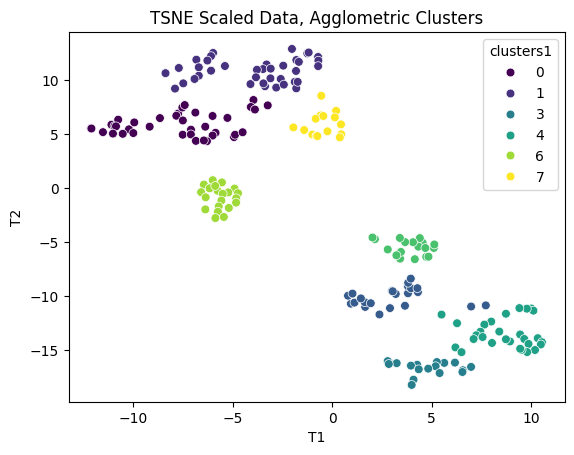

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(scaled.drop("clusters1", axis=1))

tsne_data = pd.DataFrame(tsne_data, columns = ["T1","T2"])
scaled = pd.concat([scaled, tsne_data], axis=1)

sns.scatterplot(data = scaled, x=scaled["T1"], y=scaled["T2"], hue = scaled["clusters1"], s=40, palette="viridis")
plt.xlabel("T1")
plt.ylabel("T2")
plt.title("TSNE Scaled Data, Agglometric Clusters")
plt.show()

In [66]:
# we didn't do the PCA as we found that PCA 1 and 2 only has 70% of the variance, so no real statitical interpretation can be derived as as adding more PC will make sense
# tsne is pure for visualization purpose it clusters similarities so this part is just for visual inspection, it does not hold any mathematical interpretation  

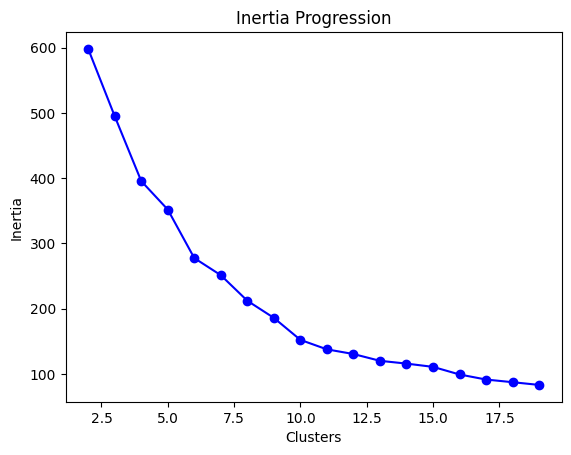

In [67]:
inertia = []
for k in range(2,20):
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(scaled.drop(["clusters1","T1","T2"], axis=1))
    inertia.append(kmeans.inertia_)

plt.plot(range(2,20), inertia, "bo-")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.title("Inertia Progression")
plt.show()

In [68]:
# Fun excercise, instead of using full dataset let's se if sample from K-Means clusters and validate if the sample is representative

kmeans = KMeans(n_clusters=5, random_state=42)
scaled["clusters2"] = kmeans.fit_predict(scaled.drop(["clusters1","T1","T2"], axis=1))
sample_size = int(0.5 * len(scaled)) # 30% sample
print(sample_size)
sample = scaled.groupby("clusters2", group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state = 42))
print(f"Sampled dataset shape: {sample.shape}")
print(sample["clusters2"].value_counts())

100
Sampled dataset shape: (100, 8)
clusters2
0    26
3    24
2    21
4    19
1    10
Name: count, dtype: int64


In [69]:
from statsmodels.stats.power import TTestIndPower
# Define power analysis
analysis = TTestIndPower()
effect_size = 0.5  # Medium effect size
alpha = 0.05       # 5% significance level
power = 0.8        # 80% power

# Compute required sample size
required_n = analysis.solve_power(effect_size, power=power, alpha=alpha)
print(f"Required sample size per cluster: {int(required_n)}")

Required sample size per cluster: 63


In [70]:
# we can see that we can't sample the data, in fact our data is not even true representatitve of the distribution as per this example
# our power t test is also not valid because only 1 attribute appears to be following gaussian distribution, as shown in the following diagrams

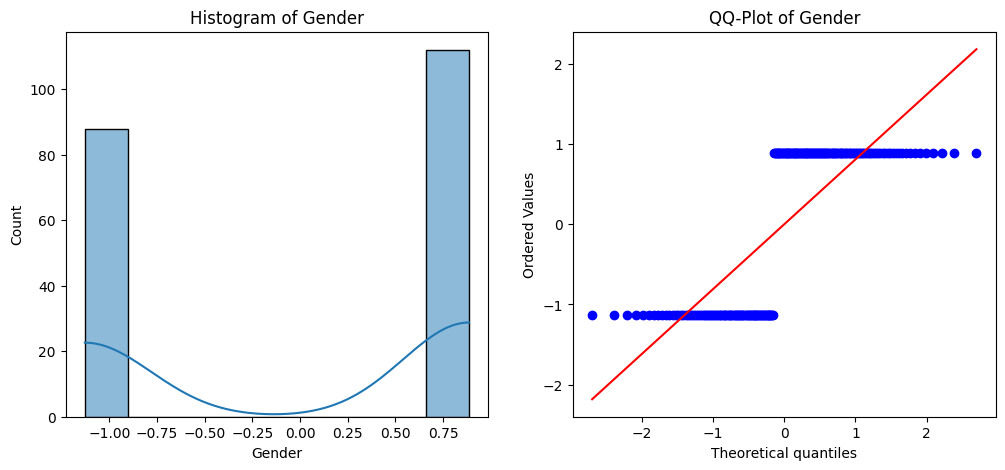

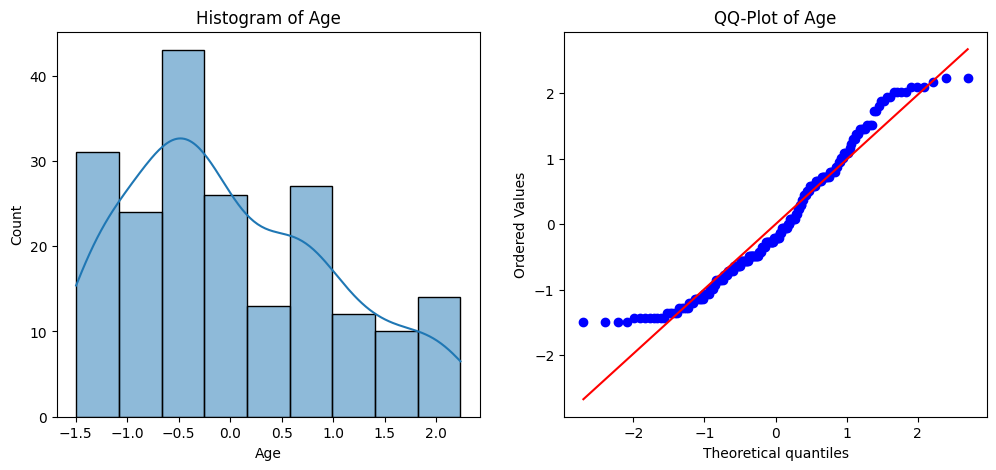

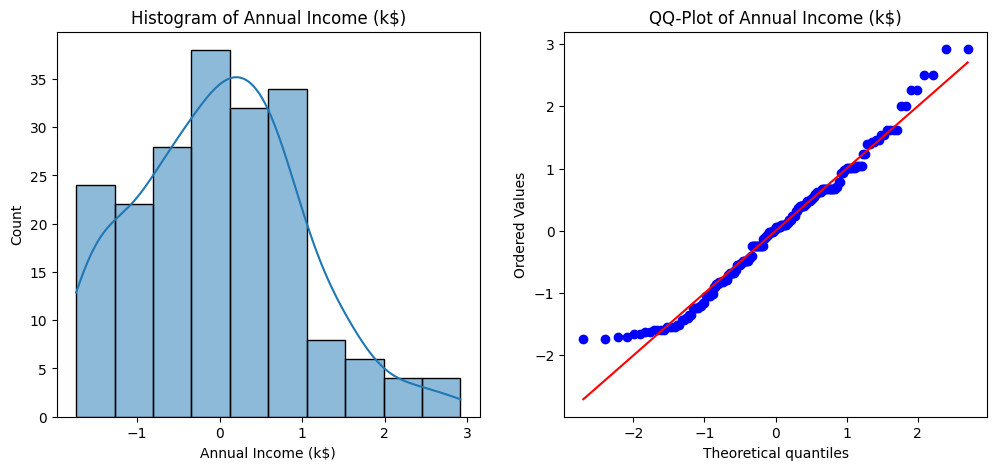

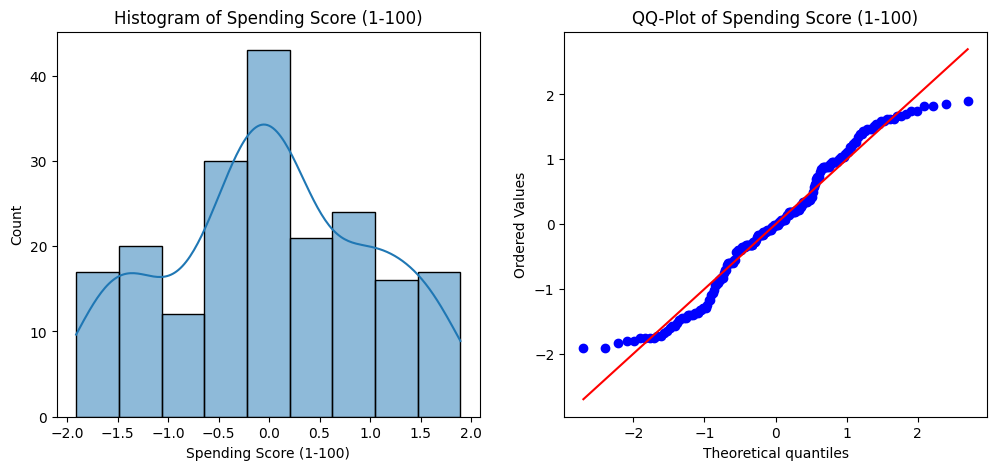

In [71]:
import scipy.stats as stats

# Select features
features = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for feature in features:
    plt.figure(figsize=(12, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(scaled[feature], kde=True)
    plt.title(f'Histogram of {feature}')

    # QQ-Plot
    plt.subplot(1, 2, 2)
    stats.probplot(scaled[feature], dist="norm", plot=plt)
    plt.title(f'QQ-Plot of {feature}')

    plt.show()


In [72]:
# we can further our analysis using some parametric and non parametric tests to see if sampling can work

In [73]:
# let us continue with the analysis of the sampling

# 2️⃣ Kolmogorov-Smirnov (KS) Test (For Age, Income, Spending Score)
# ✅ Confirmed Correct

# Type of Data: Continuous.
# Assumptions: No assumptions on normality, so it works for non-Gaussian data.
# Test Choice: Since KS compares two distributions (sample vs. population), it is the right test.
# 🔍 Final Check:

# KS Test is best for large samples. If the sample is small, the Anderson-Darling Test may be more sensitive.

# 3️⃣ Mann-Whitney U Test (For Age)
# ✅ Confirmed Correct

# Type of Data: Continuous, but not normally distributed (confirmed from histogram & QQ plot).
# Assumptions:
# Works for non-Gaussian data.
# Compares medians, not means.
# Test Choice: Since we are checking if the age distribution in the sample is similar to the population, this is correct.
# 🔍 Final Check:

# If age distributions are very different in shape, we should consider the Kolmogorov-Smirnov test instead.
# 4️⃣ T-Test (For Income & Spending Score)
# ✅ Confirmed Correct

# Type of Data: Continuous and approximately Gaussian (from QQ plot).
# Assumptions:
# Sample should follow a normal distribution (which spending score does, and income is "roughly" normal).
# Compares means, not medians.
# Test Choice: Since both income and spending score follow normality and we are testing means, the t-test is correct.
# 🔍 Final Check:

# If normality is not met for income, we should use Mann-Whitney U test instead of t-test.
# Final Decision on Tests:
# Feature	Distribution	Test Used
# Gender	Categorical (Bernoulli)	Fisher exact test
# Age	Non-Gaussian	Mann-Whitney U Test
# Annual Income	Approx. Gaussian	T-Test (or Mann-Whitney if needed)
# Spending Score	Gaussian	T-Test


In [74]:
sample = scaled.groupby("Gender", group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state = 42))
print(sample.shape, sample["Gender"].value_counts())

(140, 8) Gender
 0.886405    78
-1.128152    62
Name: count, dtype: int64


In [75]:
# Interpreting Fisher’s Test Results
# P-value > 0.05 → Sample represents the full dataset well (no significant difference).
# P-value ≤ 0.05 → Sample is significantly different from the full dataset (not representative)

In [76]:
# Get gender counts ensuring both categories exist in both datasets
full_gender_counts = list(scaled['Gender'].value_counts())
sample_gender_counts = list(sample['Gender'].value_counts())
from scipy.stats import fisher_exact

# Create a contingency table
contingency_table = [full_gender_counts, sample_gender_counts]  # Example: [[112, 88], [78, 62]]

# Perform Fisher's Exact Test
odds_ratio, fisher_p_val = fisher_exact(contingency_table)

print(f"Fisher’s Exact Test: Odds Ratio = {odds_ratio}, P-value = {fisher_p_val}")

Fisher’s Exact Test: Odds Ratio = 1.0116550116550116, P-value = 1.0


In [77]:
# our Gender data is representative

In [78]:
# Mann-Whitney U Test 
# How It Works?
# Null Hypothesis (H₀): The sample and population medians are the same.
# Alternative Hypothesis (H₁): The sample and population medians are different.
# If p-value > 0.05, we fail to reject H₀, meaning the sample is representative.

In [79]:
# Mann-Whitney U Test for Age
mw_stat_age, mw_p_val_age = stats.mannwhitneyu(scaled['Age'], sample['Age'])
print(f"Mann-Whitney U Test for Age: U-statistic = {mw_stat_age}, P-value = {mw_p_val_age}")

# Mann-Whitney U Test for Annual Income
mw_stat_income, mw_p_val_income = stats.mannwhitneyu(scaled['Annual Income (k$)'], sample['Annual Income (k$)'])
print(f"Mann-Whitney U Test for Annual Income: U-statistic = {mw_stat_income}, P-value = {mw_p_val_income}")

Mann-Whitney U Test for Age: U-statistic = 13888.0, P-value = 0.9004829932519384
Mann-Whitney U Test for Annual Income: U-statistic = 14800.0, P-value = 0.3698970198083721


In [80]:
# Age passes, Annual income also passes

In [81]:
# KS
# How It Works?
# Null Hypothesis (H₀): The sample follows the same distribution as the population.
# Alternative Hypothesis (H₁): The sample and population distributions are different.
# If p-value > 0.05, the sample and population are not significantly different, meaning our sample is valid.

In [82]:
# Kolmogorov-Smirnov test for Spending Score
ks_stat, ks_p_val = stats.ks_2samp(scaled['Spending Score (1-100)'], sample['Spending Score (1-100)'])
print(f"KS Test for Spending Score: KS-statistic = {ks_stat}, P-value = {ks_p_val}")

KS Test for Spending Score: KS-statistic = 0.023571428571428573, P-value = 0.9999999988625837


In [83]:
# our sample for the Spending Score is representative

In [84]:
# T-Test
# How It Works?
# Null Hypothesis (H₀): The sample mean is the same as the population mean.
# Alternative Hypothesis (H₁): The sample mean is different.
# If p-value > 0.05, we fail to reject H₀, meaning the sample is representative.

In [85]:
# T-test: Spending Score (parametric test)
t_stat, p_val_spending = stats.ttest_ind(scaled['Spending Score (1-100)'], sample['Spending Score (1-100)'])
print(f"T-test for Spending Score: T-statistic = {t_stat}, P-value = {p_val_spending}")

T-test for Spending Score: T-statistic = 0.055642487323466445, P-value = 0.9556594928944647


In [86]:
# sample is representative so we can use Spending Score sample, it is also valid because of the power of t test
# lets see the clustering then

In [87]:
sample_relevant = sample.drop(["T1", "T2", "clusters1", "clusters2"], axis=1)

In [88]:
sample_relevant.reset_index(drop=True, inplace=True)

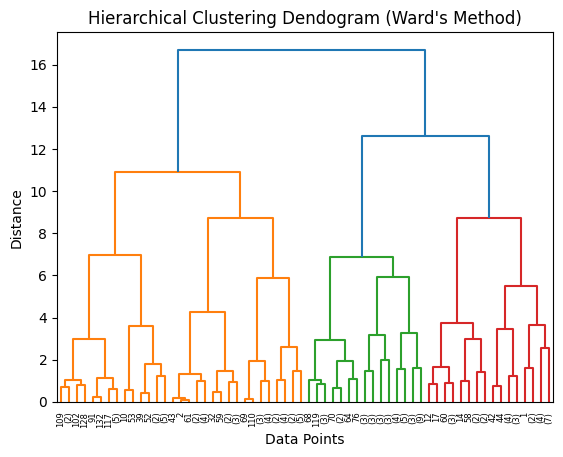

In [89]:
linkages = linkage(sample_relevant ,method="ward")
dendrogram(linkages, truncate_mode = "level", p=5)
plt.title("Hierarchical Clustering Dendogram (Ward's Method)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

In [90]:
# dendograms looks same as the previous one

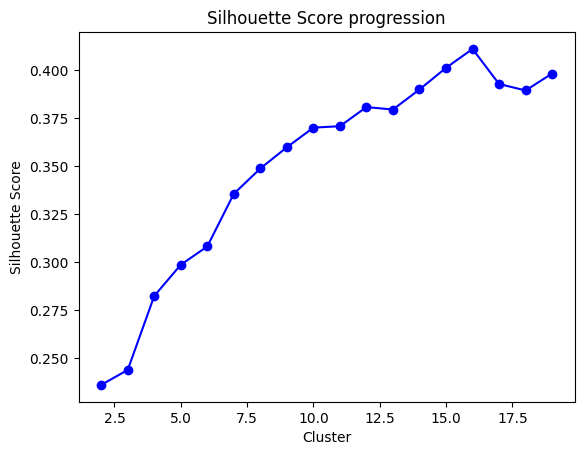

In [91]:
for_diag = []
for n_clusters in range(2,20):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage = "ward")
    labels = clusterer.fit_predict(sample_relevant)
    silhouette_avg = silhouette_score(sample_relevant, labels)
    for_diag.append(silhouette_avg)

plt.plot(range(2,20), for_diag, "bo-")
plt.xlabel("Cluster")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score progression")
plt.show()


In [92]:
# silhoute score differ, optimal looks like 15+

In [93]:
final_clusters = AgglomerativeClustering(n_clusters=16, linkage="ward")
sample_relevant["clusters1"] = final_clusters.fit_predict(sample_relevant)

In [94]:
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(sample_relevant.drop("clusters1", axis=1))

tsne_data = pd.DataFrame(tsne_data, columns = ["T1","T2"])
sample_relevant = pd.concat([sample_relevant, tsne_data], axis=1)

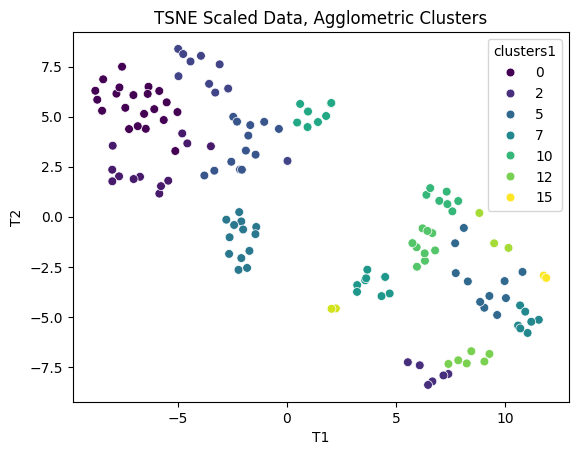

In [95]:
sns.scatterplot(data = sample_relevant, x=sample_relevant["T1"], y=sample_relevant["T2"], hue = sample_relevant["clusters1"], s=40, palette="viridis")
plt.xlabel("T1")
plt.ylabel("T2")
plt.title("TSNE Scaled Data, Agglometric Clusters")
plt.show()

In [96]:
# clearly agglometric clustering did a bad job

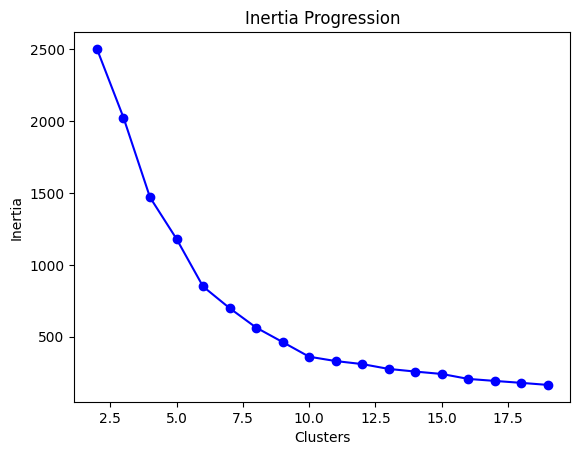

In [97]:
inertia = []
for k in range(2,20):
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(sample_relevant.drop(["clusters1"], axis=1))
    inertia.append(kmeans.inertia_)

plt.plot(range(2,20), inertia, "bo-")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.title("Inertia Progression")
plt.show()

In [98]:
sample_relevant = sample_relevant[features]

In [99]:
kmeans = KMeans(n_clusters=5, random_state=42)
sample_relevant["clusters2"] = kmeans.fit_predict(sample_relevant)

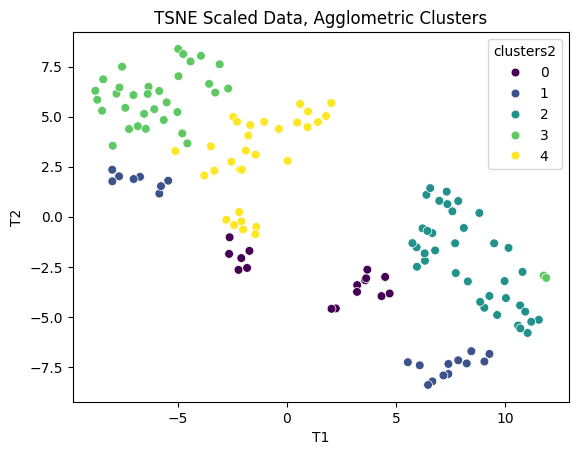

In [100]:
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(sample_relevant.drop("clusters2", axis=1))

tsne_data = pd.DataFrame(tsne_data, columns = ["T1","T2"])
sample_relevant = pd.concat([sample_relevant, tsne_data], axis=1)

sns.scatterplot(data = sample_relevant, x=sample_relevant["T1"], y=sample_relevant["T2"], hue = sample_relevant["clusters2"], s=40, palette="viridis")
plt.xlabel("T1")
plt.ylabel("T2")
plt.title("TSNE Scaled Data, Agglometric Clusters")
plt.show()

In [101]:
# k means too did a bad job

In [102]:
# Analysis of the Findings
# You observed three key results after running clustering on the sample data:

# Silhouette Score suggests an increase in optimal clusters (from 8 to 15)
# Elbow Method remains unchanged
# t-SNE visualization shows poor clustering quality
# Let's break down why this is happening and what it means.

# 1. Why Did the Silhouette Score Suggest More Clusters?
# The silhouette score measures how similar a point is to its own cluster vs. other clusters.

# In the original dataset, the clustering found a structure where 8 clusters made sense.
# But in the sampled dataset, the structure may have changed, introducing more distinct clusters artificially.
# This happens because sampling changed the distribution of the data → resulting in different cluster distances. It measures cluster compactness & separation (variance explained).
# The increase in the number of clusters (from 8 to 15) suggests that the sample is not fully representative of the original data.
# 📌 Key takeaway: The sample overemphasizes certain patterns, leading to more clusters than necessary.

# 2. Why Did the Elbow Method Stay the Same?
# The Elbow Method measures inertia (sum of squared distances from points to cluster centers).
# Since inertia is less sensitive to minor distribution changes, it did not change much even though silhouette scores suggested more clusters. Elbow measures variance explained.
# However, inertia alone cannot tell us if the clusters are meaningful.
# 📌 Key takeaway: The elbow method alone is not enough to determine the best number of clusters.

# 3. Why Did t-SNE Show Poor Clustering?
# t-SNE is a non-linear dimensionality reduction technique that preserves local structure.
# If clusters overlap or become distorted after sampling, t-SNE will struggle to separate them properly.
# This means the sample does not preserve the same cluster structure as the original dataset.
# 📌 Key takeaway: The sample distorted the true cluster relationships, leading to poor clustering results.

# Final Inference
# Sampling changed the data distribution, affecting clustering performance.
# The new clusters (15) are likely artificial and do not represent true groupings.
# Elbow method was stable, but silhouette score and t-SNE suggest that the sample does not preserve the original data structure.
# This means our sample might not be fully representative → We need a better sampling approach.